# **Assignment 3**

**Obtaining and preparing the MNIST dataset**

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

In [4]:
# Install scikit-learn if it's not already installed
!pip install scikit-learn

In [5]:
!pip install openml


  Using cached openml-0.15.1-py3-none-any.whl.metadata (10 kB)
  Using cached liac_arff-2.5.0-py3-none-any.whl
  Using cached minio-7.2.15-py3-none-any.whl.metadata (6.7 kB)
Using cached openml-0.15.1-py3-none-any.whl (160 kB)
Using cached minio-7.2.15-py3-none-any.whl (95 kB)


In [6]:
import openml

# Download the MNIST dataset by specifying the dataset ID
dataset = openml.datasets.get_dataset(554)

# Get the features (X) and labels (y) as pandas DataFrames
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
X = X.values
y = y.astype(int).values

# Print the shape of the data
print("Shape of X (features):", X.shape)  # (70000, 784)
print("Shape of y (labels):", y.shape)  # (70000,)


Shape of X (features): (70000, 784)
Shape of y (labels): (70000,)


Normalize to [-1, 1] range:

In [7]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

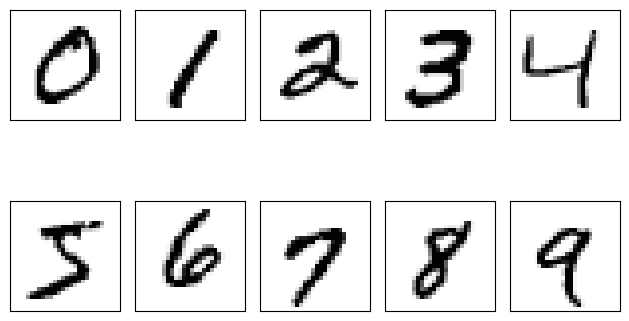

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

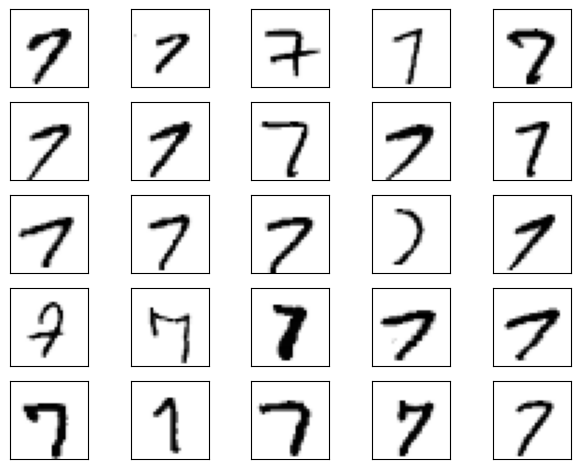

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

# Implementing a multi-layer perceptron

In [10]:
import numpy as np

  ## **Revised for 2 hidden layers**

In [11]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, sec_num_hidden ,num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # second hidden layer
        self.weight_h_2 = rng.normal(
            loc=0.0, scale=0.1, size=(sec_num_hidden, num_hidden))
        self.bias_h_2 = np.zeros(sec_num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # second hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h_2 = np.dot(a_h, self.weight_h_2.T) + self.bias_h_2
        a_h_2 = sigmoid(z_h_2)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h_2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_h_2, a_out

    def backward(self, x, a_h, a_h_2, a_out, y):
        #########################
        ### Output layer gradients
        #########################

        # One-hot encoding of y
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]  # Loss derivative wrt output activations
        d_a_out__d_z_out = a_out * (1. - a_out)  # Sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out  # Delta for output layer

        # Gradient for output weights and biases
        d_loss__dw_out = np.dot(delta_out.T, a_h_2)  # [n_classes, n_hidden_2]
        d_loss__db_out = np.sum(delta_out, axis=0)  # [n_classes]

        ##########################
        ### Second hidden layer gradients
        ##########################

        d_z_out__a_h_2 = self.weight_out  # [n_classes, n_hidden_2]
        d_loss__a_h_2 = np.dot(delta_out, d_z_out__a_h_2)  # [n_examples, n_hidden_2]

        d_a_h_2__d_z_h_2 = a_h_2 * (1. - a_h_2)  # Sigmoid derivative for second hidden layer
        delta_h_2 = d_loss__a_h_2 * d_a_h_2__d_z_h_2  # Delta for second hidden layer

        # Gradient for second hidden layer weights and biases
        d_loss__d_w_h_2 = np.dot(delta_h_2.T, a_h)  # [n_hidden_2, n_hidden_1]
        d_loss__d_b_h_2 = np.sum(delta_h_2, axis=0)  # [n_hidden_2]

        ##########################
        ### First hidden layer gradients
        ##########################

        d_z_h_2__a_h = self.weight_h_2  # [n_hidden_2, n_hidden_1]
        d_loss__a_h = np.dot(delta_h_2, d_z_h_2__a_h)  # [n_examples, n_hidden_1]

        d_a_h__d_z_h = a_h * (1. - a_h)  # Sigmoid derivative for first hidden layer
        delta_h = d_loss__a_h * d_a_h__d_z_h  # Delta for first hidden layer

        # Gradient for first hidden layer weights and biases
        d_loss__d_w_h = np.dot(delta_h.T, x)  # [n_hidden_1, n_features]
        d_loss__d_b_h = np.sum(delta_h, axis=0)  # [n_hidden_1]

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h_2, d_loss__d_b_h_2,
                d_loss__d_w_h, d_loss__d_b_h)

Model learned in class

In [12]:
# Solution 1: A plain deep NN : input_dims = 28*28, num_hidden = 500,  sec_num_hidden = 500, output_dims = 10
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=500,
                     sec_num_hidden=500,
                     num_classes=10)

##Splitting into train and test validation

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

# Print the shape of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (49000, 784)
Shape of X_test: (21000, 784)
Shape of y_train: (49000,)
Shape of y_test: (21000,)


## Coding the neural network training loop
Defining data loaders:

In [14]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


##Defining a function to compute the loss and accuracy

In [15]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


holer1, holder2, probas = model.forward(X_test)
mse = mse_loss(y_test, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_test, predicted_labels)

print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.2
Initial test accuracy: 9.9%


In [16]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        holer1, holder2, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [17]:
mse, acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.2
Initial valid accuracy: 9.9%


In [18]:
def train(model, X_train, y_train, X_test, y_test, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_test_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_h_2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h_2, d_loss__d_b_h_2, \
            d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_h_2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_h_2 -= learning_rate * d_loss__d_w_h_2
            model.bias_h_2 -= learning_rate * d_loss__d_b_h_2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
        train_acc, test_acc = train_acc*100, test_acc*100
        epoch_train_acc.append(train_acc)
        epoch_test_acc.append(test_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_test_acc

In [19]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_test_acc = train(
    model, X_train, y_train, X_test, y_test,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.03 | Train Acc: 84.89% | Test Acc: 84.79%
Epoch: 002/050 | Train MSE: 0.02 | Train Acc: 87.68% | Test Acc: 87.52%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 89.33% | Test Acc: 89.26%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 90.20% | Test Acc: 90.00%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.85% | Test Acc: 90.58%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 91.35% | Test Acc: 91.10%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.86% | Test Acc: 91.54%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 92.09% | Test Acc: 91.68%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 92.37% | Test Acc: 92.04%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.54% | Test Acc: 92.09%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 93.03% | Test Acc: 92.58%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 93.18% | Test Acc: 92.67%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 93.44% | Test Acc: 92.88%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 93.81% | Test Acc:

## Evaluating the neural network performance

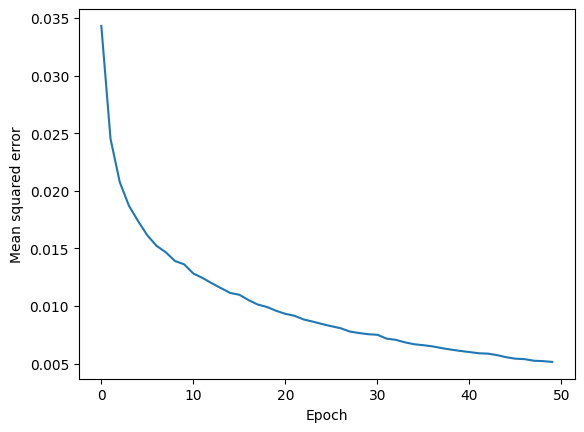

In [20]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

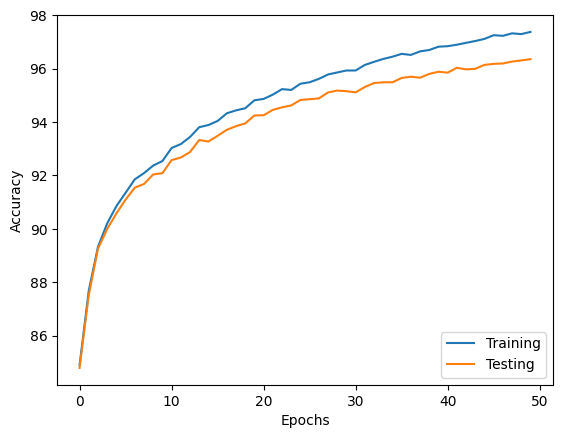

In [21]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_test_acc)), epoch_test_acc,
         label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
import numpy as np

def compute_macro_auc(nn, X, y, num_classes, batch_size):
    aucs = []
    # Generate mini-batches
    for start_idx in range(0, len(X), batch_size):
        end_idx = min(start_idx + batch_size, len(X))
        # Extract the current mini-batch
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        # Forward pass to get the predicted probabilities
        hplder1, holder2, probas = nn.forward(X_batch)
        # One-hot encode the true labels
        onehot_y_batch = int_to_onehot(y_batch, num_labels=num_classes)
        # Calculate AUC for this mini-batch
        auc = roc_auc_score(onehot_y_batch, probas, average='macro', multi_class='ovo')
        aucs.append(auc)
    return np.mean(aucs)

# Compute the Macro AUC on the test data
test_auc = compute_macro_auc(model, X_test, y_test, 10, 100)
print(f'Test Macro AUC: {test_auc * 100:.2f}%')


Test Macro AUC: 99.67%


In [23]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 96.36%


Model Test Accuracy: 96.36%
Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2071
           1       0.98      0.98      0.98      2363
           2       0.97      0.95      0.96      2097
           3       0.97      0.94      0.96      2142
           4       0.97      0.96      0.96      2047
           5       0.95      0.95      0.95      1894
           6       0.97      0.97      0.97      2063
           7       0.96      0.97      0.96      2188
           8       0.95      0.96      0.96      2048
           9       0.95      0.96      0.95      2087

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000

Model Confusion Matrix:
[[2036    0    2    0    0    8   12    3    7    3]
 [   0 2326    7    3    6    6    3    5    3    4]
 [  15   10 1997    5   12    3    8   23   19    5]
 

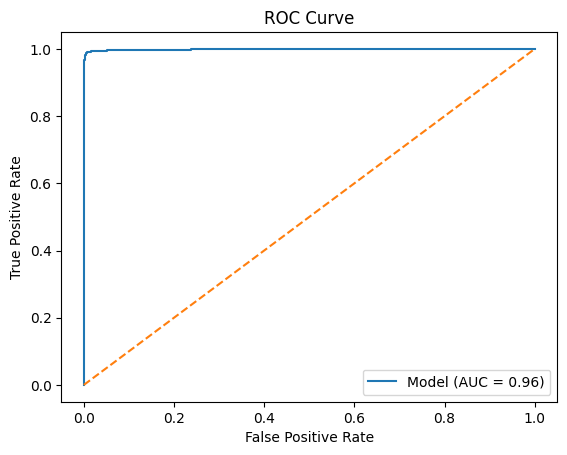

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import time
import numpy as np
import matplotlib.pyplot as plt


# Function to evaluate second model
def evaluate_model_MLP(model, X_test, y_test):
    # Forward pass
    a_h, a_h_2, a_out = model.forward(X_test)

    # Calculate AUC-macro (use sigmoid output for probabilities)
    probas = a_out  # Probabilities for multi-class classification

    # Calculate accuracy
    predictions = np.argmax(probas, axis=1)
    accuracy = np.mean(predictions == y_test) * 100

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)

    # Classification Report (Precision, Recall, F1)
    report = classification_report(y_test, predictions)

    return accuracy, cm, report, probas

# Evaluate the NumPy-based model
start_time = time.time()
accuracy_2, cm_2, report_2, probas_2 = evaluate_model_MLP(model, X_test, y_test)
end_time = time.time()

print(f"Model Test Accuracy: {accuracy_2:.2f}%")
print(f"Model Classification Report:\n{report_2}")
print(f"Model Confusion Matrix:\n{cm_2}")
print(f"Model Inference Time: {end_time - start_time:.2f} seconds")

# Plot ROC curve for Model 2
fpr, tpr, _ = roc_curve(y_test, probas_2[:, 1], pos_label=1)
plt.plot(fpr, tpr, label="Model (AUC = {:.2f})".format(test_acc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


##Plot failure cases:

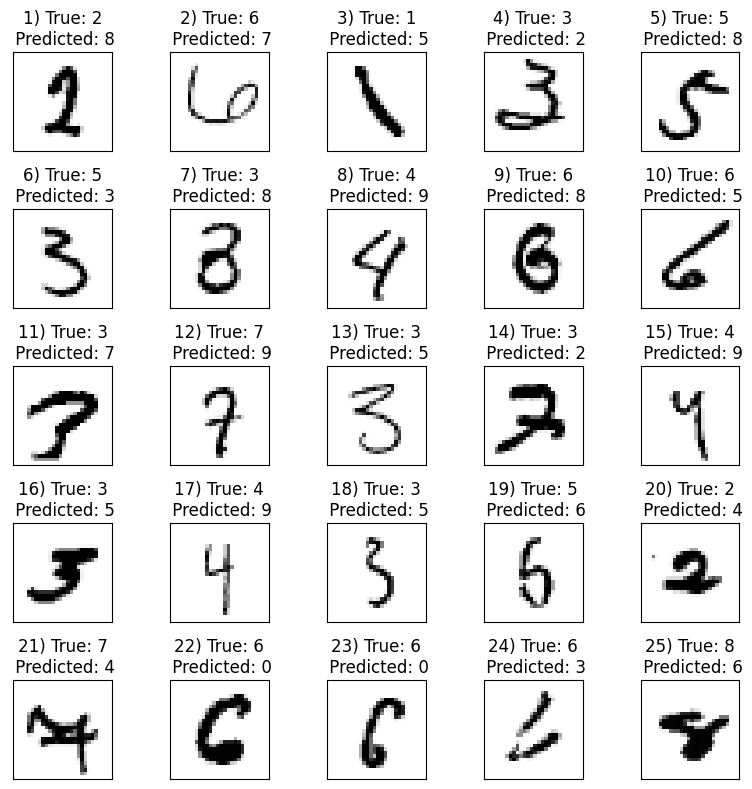

In [29]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

holder1, holder2, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

##**Fully connected ANN using pyTorch**


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

# Prepare the data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        x = self.layer3(x)  # Output layer without activation for classification
        return x

# Instantiate the model
model = SimpleNN(input_dim=28*28, hidden_dim=500, output_dim=10)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/50], Loss: 0.4651
Epoch [2/50], Loss: 0.1814
Epoch [3/50], Loss: 0.1268
Epoch [4/50], Loss: 0.0993
Epoch [5/50], Loss: 0.0786
Epoch [6/50], Loss: 0.0650
Epoch [7/50], Loss: 0.0566
Epoch [8/50], Loss: 0.0460
Epoch [9/50], Loss: 0.0404
Epoch [10/50], Loss: 0.0358
Epoch [11/50], Loss: 0.0320
Epoch [12/50], Loss: 0.0290
Epoch [13/50], Loss: 0.0263
Epoch [14/50], Loss: 0.0219
Epoch [15/50], Loss: 0.0214
Epoch [16/50], Loss: 0.0205
Epoch [17/50], Loss: 0.0183
Epoch [18/50], Loss: 0.0170
Epoch [19/50], Loss: 0.0176
Epoch [20/50], Loss: 0.0164
Epoch [21/50], Loss: 0.0144
Epoch [22/50], Loss: 0.0151
Epoch [23/50], Loss: 0.0131
Epoch [24/50], Loss: 0.0116
Epoch [25/50], Loss: 0.0129
Epoch [26/50], Loss: 0.0121
Epoch [27/50], Loss: 0.0129
Epoch [28/50], Loss: 0.0104
Epoch [29/50], Loss: 0.0130
Epoch [30/50], Loss: 0.0120
Epoch [31/50], Loss: 0.0115
Epoch [32/50], Loss: 0.0103
Epoch [33/50], Loss: 0.0118
Epoch [34/50], Loss: 0.0095
Epoch [35/50], Loss: 0.0090
Epoch [36/50], Loss: 0.0098
E

Model Test Accuracy: 97.68%
Model Test Macro AUC: 99.95%
Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2071
           1       0.99      0.99      0.99      2363
           2       0.96      0.98      0.97      2097
           3       0.98      0.97      0.97      2142
           4       0.99      0.97      0.98      2047
           5       0.98      0.96      0.97      1894
           6       0.97      0.99      0.98      2063
           7       0.98      0.97      0.98      2188
           8       0.96      0.98      0.97      2048
           9       0.97      0.97      0.97      2087

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000

Model Confusion Matrix:
[[2051    0    2    0    0    3    9    1    3    2]
 [   0 2347    6    3    1    0    0    2    2    2]
 [   5    3 2056    5    

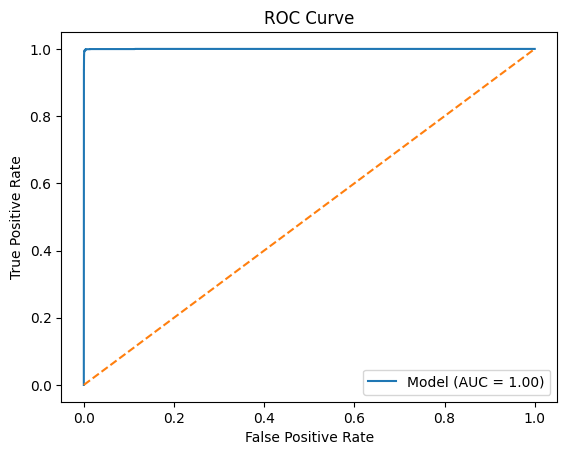

In [31]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import time

# Function to evaluate model
def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_test_tensor).sum().item()
        accuracy = correct / y_test_tensor.size(0) * 100

        # Calculate AUC-macro
        probas = torch.nn.functional.softmax(outputs, dim=1).numpy()  # Get probabilities
        test_auc = roc_auc_score(y_test_tensor.numpy(), probas, average='macro', multi_class='ovo')

        # Confusion Matrix
        cm = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())

        # Classification Report (Precision, Recall, F1)
        report = classification_report(y_test_tensor.numpy(), predicted.numpy())

        return accuracy, test_auc, cm, report, probas

# Evaluate the PyTorch model
start_time = time.time()
accuracy_1, auc_1, cm_1, report_1, probas_1 = evaluate_model(model, X_test_tensor, y_test_tensor)
end_time = time.time()

print(f"Model Test Accuracy: {accuracy_1:.2f}%")
print(f"Model Test Macro AUC: {auc_1*100:.2f}%")
print(f"Model Classification Report:\n{report_1}")
print(f"Model Confusion Matrix:\n{cm_1}")
print(f"Model Inference Time: {end_time - start_time:.2f} seconds")

# Plot ROC curve for Model 1
fpr, tpr, _ = roc_curve(y_test_tensor.numpy(), probas_1[:, 1], pos_label=1)
plt.plot(fpr, tpr, label="Model (AUC = {:.2f})".format(auc_1))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


##**Comparison**

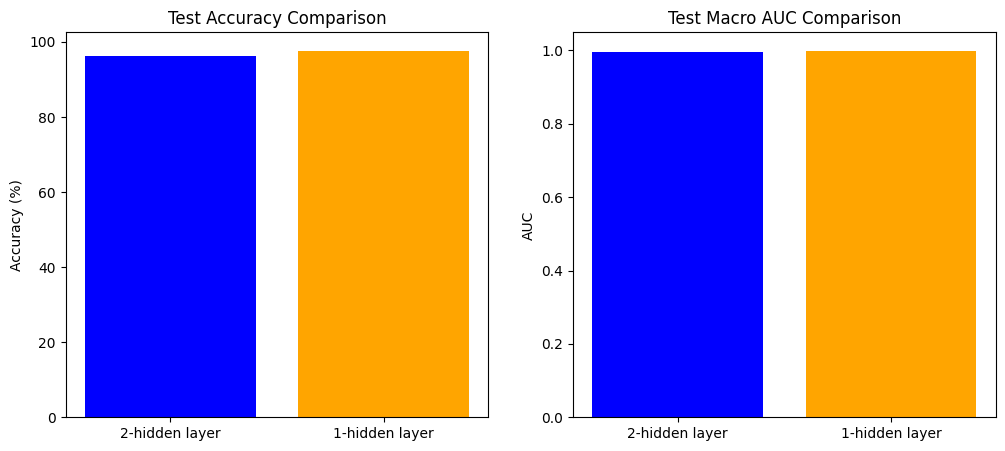

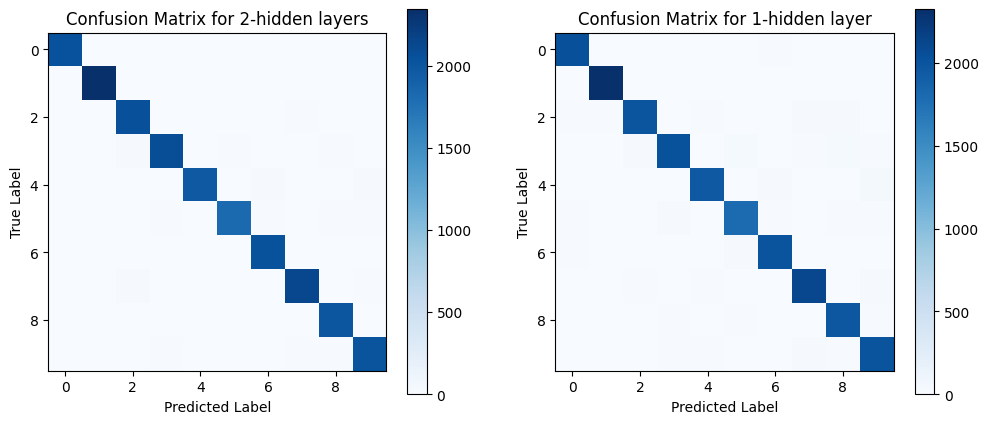

In [35]:
# Create a bar chart comparing accuracy and AUC for both models
labels = ['2-hidden layer', '1-hidden layer']
accuracy_scores = [test_acc*100, accuracy_1]
auc_scores = [test_auc, auc_1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Plot
ax[0].bar(labels, accuracy_scores, color=['blue', 'orange'])
ax[0].set_title('Test Accuracy Comparison')
ax[0].set_ylabel('Accuracy (%)')

# AUC Plot
ax[1].bar(labels, auc_scores, color=['blue', 'orange'])
ax[1].set_title('Test Macro AUC Comparison')
ax[1].set_ylabel('AUC')

plt.show()

# Confusion Matrices for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Model 1 Confusion Matrix
ax1.imshow(cm_1, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix for 2-hidden layers')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
plt.colorbar(ax1.imshow(cm_1, interpolation='nearest', cmap=plt.cm.Blues), ax=ax1)

# Model 2 Confusion Matrix
ax2.imshow(cm_2, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix for 1-hidden layer')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
plt.colorbar(ax2.imshow(cm_2, interpolation='nearest', cmap=plt.cm.Blues), ax=ax2)

plt.show()
